In [2]:
import torch

from pina.problem import SpatialProblem, TimeDependentProblem
from pina.operators import nabla, grad, div, curl, advection
from pina import Condition, Span, LabelTensor
from scipy.linalg import norm
import numpy as np



class QGE(SpatialProblem, TimeDependentProblem):

    output_variables = ['q', 'si', 'fq']
    spatial_domain = Span({'x': [0, 1], 'y': [-1, 1]})
    temporal_domain = Span({'t': [0, 1]})
    # non dimentionlaise the equation and make t, 1 to 100
    
    def rand_choice_integer_Data(self):
        pass 
    
    def eq1(input_, output_):
        nu = 0.0022
        Re = 100 / nu
        
        #convective term
        si_curl = curl(output_.extract(['si']), input_, d = ['x', 'y'])
        convective_ = advection(output_.extract(['q']), input_, velocity_field = si_curl, d = ['x', 'y'])
        
        #diffusive term
        diffusive_ = nabla(output_.extract(['q']), input_, d = ['x', 'y'])   
        
        #transient term 
        du = grad(output_.extract(['q']), input_)
        transient_ = du.extract('dqdt')
        
        #forcing term
        force_ = torch.sin(torch.pi * input_.extract(['y']))
        
        print(f"transient: {transient_.shape}")
        print(f"convective: {convective_.shape}")
        print(f"diffusive: {diffusive_.shape}")
        print(f"diffusive: {force_.shape}")
        
        
        return transient_ + convective_ - (1/Re) * diffusive_ - force_
    
    def eq2(input_, output_):
        r0 = 0.0036
        
        #second equation
        output = output_.extract(['fq']) + r0 * nabla(output_.extract(['si']), input_, d = ['x', 'y']) - input_.extract(['y'])
        print(f"eq2: {output.shape}")
        return output
    
    def filter_eq(input_, output_):
        alpha = 0.25 # delta y, grid size
        du = grad(output_.extract(['q']), input_)

        # Calculate the L2 norm (Euclidean norm) using PyTorch operations
        result_norm = torch.sqrt(du.extract('dqdx')**2 + du.extract('dqdy')**2)
        
        # Apply the infinity norm (max) along the last axis using torch.max
        result_inf_norm = torch.max(torch.abs(du.extract('dqdx')), torch.abs(du.extract('dqdy')))
        
        # Calculate the max(1, L∞ norm) using torch.max
        max_norm = torch.max(torch.tensor(1.0), result_inf_norm)
        
        # Calculate the indicator function a(q)
        aq = result_norm / max_norm
            
        #equation
        d = ['x','y']
        components = ['fq', 'fq']
        result = torch.empty(input_.shape[0], len(components),
                                 device=output_.device)
        
        labels = [None] * len(components)
        for idx, (ci, di) in enumerate(zip(components, d)):
           
            grad_output = grad(output_, input_, components=[ci], d=[di])
            grad_output = torch.mul(aq, grad_output)
            label = [f'd{ci}d{di}']
            grad_output.labels = label
            
            result[:, idx] = grad(grad_output, input_, d=di).flatten()
            labels[idx] = f'dd{ci}dd{di}'
            
        # print(result.shape)
        # result = result.as_subclass(LabelTensor)
        # result.labels = labels
         
        filter = -(alpha)**2 * result + output_.extract(['fq']) - output_.extract(['q'])
        filter = torch.sum(filter, dim=1).unsqueeze(1)
        print(f"filter: {filter.shape}")
        return filter
        
    def continuity(input_, output_):
        si_curl = curl(output_.extract(['si']), input_, d = ['x', 'y'])
        out = div(si_curl, input_, d = ['x', 'y'])
        print(f"continuity: {out.shape}")
        return out

    def initial_si(input_, output_):
        value = 0.0
        print(f"initial_si: {(output_.extract(['si'])- value).shape}")
        return output_.extract(['si']) - value
    
    # change it to fq instead of q
    def zeta(input_, output_):
        value = input_.extract(['y'])
        print(f"zeta: {(output_.extract(['q']) - value).shape}")
        return output_.extract(['q']) - value
    
    def filter_zeta(input_, output_):
        value = input_.extract(['y'])
        print(f"zeta: {(output_.extract(['fq']) - value).shape}")
        return output_.extract(['fq']) - value
    
    def si(input_, output_):
        si_expected = 0.0
        print(f"si: {(output_.extract(['si'])- si_expected).shape}")
        return output_.extract(['si']) - si_expected
        
    
    conditions = {
        't0': Condition(Span({'x': [0, 1], 'y': [-1, 1], 't' : 0}), [initial_si, zeta]),
        
        'upper': Condition(Span({'x':  [0,1], 'y': 1, 't': [0,1]}), [si, zeta]),
        'fixedWall1': Condition(Span({'x':  0, 'y': [-1,1], 't': [0,1]}), [si, zeta]),
        'fixedWall2': Condition(Span({'x':  1, 'y': [-1,1], 't': [0,1]}), [si, zeta]),
        'fixedWall3': Condition(Span({'x':  [0,1], 'y': -1, 't': [0,1]}), [si, zeta]),
        
        # 'D': Condition(Span({'x': [0, 1], 'y': [-1, 1], 't': [0, 1]}), [eq1, eq2, filter_eq]),
    }


In [3]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import os

res= 25
def plot(pinn, components=None, fixed_variables={}, method='contourf',
         filename=None, **kwargs):
    if components is None:
        components = [pinn.problem.output_variables]
        
    v = [
        var for var in pinn.problem.input_variables
        if var not in fixed_variables.keys()
    ]
    
    try:
        # Ensure res is used as an integer where required
        res_int = int(res)  # Convert resolution to integer if required
        
        # Sample points
        pts = pinn.problem.domain.sample(res, 'grid', variables=v)
        
        print(f"Sampled points shape: {pts.shape}")
        
        fixed_pts = torch.ones(pts.shape[0], len(fixed_variables))
        fixed_pts *= torch.tensor(list(fixed_variables.values()))
        fixed_pts = fixed_pts.as_subclass(LabelTensor)
        fixed_pts.labels = list(fixed_variables.keys())
        
        pts = pts.append(fixed_pts)
        pts = pts.to(device=pinn.device)
        
        print(f"Points after appending fixed variables shape: {pts.shape}")
        
        # Predict output
        predicted_output = pinn.model(pts)
        print(f"Predicted output shape: {predicted_output.shape}")
        
        if isinstance(components, str):
            predicted_output = predicted_output.extract(components)
        elif callable(components):
            predicted_output = components(predicted_output)
        
        # Convert to NumPy arrays
        predicted_output_array = predicted_output.detach().cpu().numpy()
        pts_array = pts.detach().cpu().numpy()
        
        print(f"Predicted output array shape: {predicted_output_array.shape}")
        print(f"Points array shape: {pts_array.shape}")
        
        # Create DataFrames
        df_predicted_output = pd.DataFrame(predicted_output_array, columns=['Prediction'])
        df_pts = pd.DataFrame(pts_array, columns=[f'Variable_{i}' for i in range(pts_array.shape[1])])
        
        directory = "with_filter"
        # Save to .csv files inside the specified directory
        df_predicted_output.to_csv(os.path.join(directory, "predicted_output.csv"), index=False)
        df_pts.to_csv(os.path.join(directory, "points.csv"), index=False)
        
        # Optionally, save plot
        if filename:
            plt.title(f'Output {components} with parameter {fixed_variables}')
            plt.savefig(filename)
        else:
            plt.show()
        
    except Exception as e:
        print(f"An error occurred: {e}")
        
    #change grid size to 16x32 and see if we get 4 vortices
    #try introducing closure model and see if we get 4 vortices 


In [4]:

from torch.nn import Softplus
from pina import PINN, LabelTensor
from pina.model import FeedForward
import os

#args
id_run = 0
save = False

qge_problem = QGE()
model = FeedForward(
    layers=[10, 10, 10, 10],
    output_variables=qge_problem.output_variables,
    input_variables=qge_problem.input_variables,
    func=Softplus,
)
pinn = PINN(
    qge_problem,
    model,
    lr=0.01,
    error_norm='mse',
    regularizer=1e-8)

if save:
    pinn.span_pts(
            {'n': 25, 'mode': 'grid', 'variables': 't'},
            {'n': 4, 'mode': 'grid', 'variables': 'x'},
            {'n': 8, 'mode': 'grid', 'variables': 'y'},
            locations=['t0', 'upper','fixedWall1','fixedWall2','fixedWall3'])
    
    pinn.train(15000, 1500)
    directory = "with_filter"
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    # filename = os.path.join(directory, 'qge_history_16x32{}.txt'.format(id_run))
    # with open(filename, 'w') as file_:
    #     for i, losses in pinn.history_loss.items():
    #         file_.write('{} {}\n'.format(i, sum(losses)))
            
    state_filename = os.path.join(directory, 'pina_16x32_boundary.qge')
    pinn.save_state(state_filename)

else:
    directory = "with_filter"
    state_filename = os.path.join(directory, 'pina_16x32_boundary.qge')
    pinn.load_state(state_filename)
    plot(pinn, components='si')
    # plotter.plot_loss(pinn)


Sampled points shape: torch.Size([15625, 3])
Points after appending fixed variables shape: torch.Size([15625, 3])
Predicted output shape: torch.Size([15625, 3])
Predicted output array shape: (15625, 1)
Points array shape: (15625, 3)


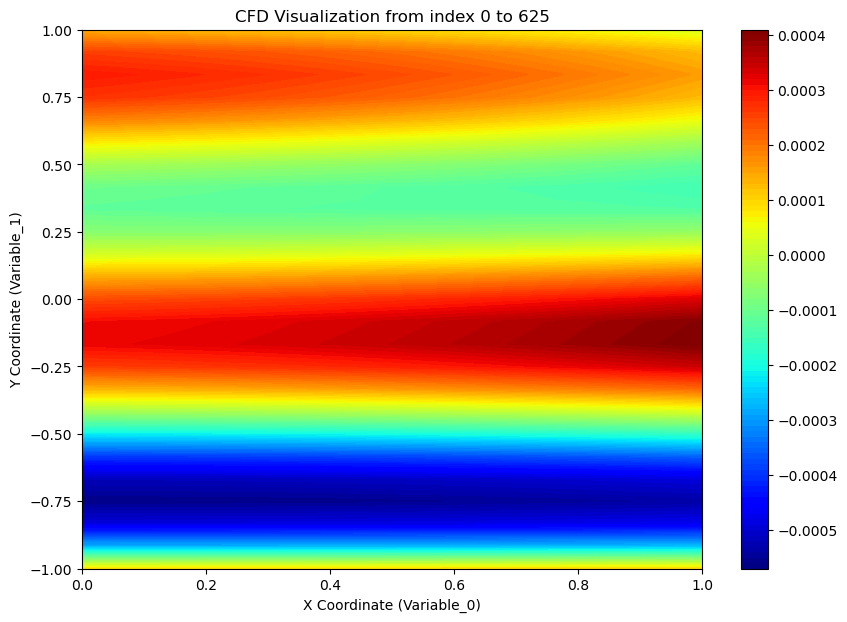

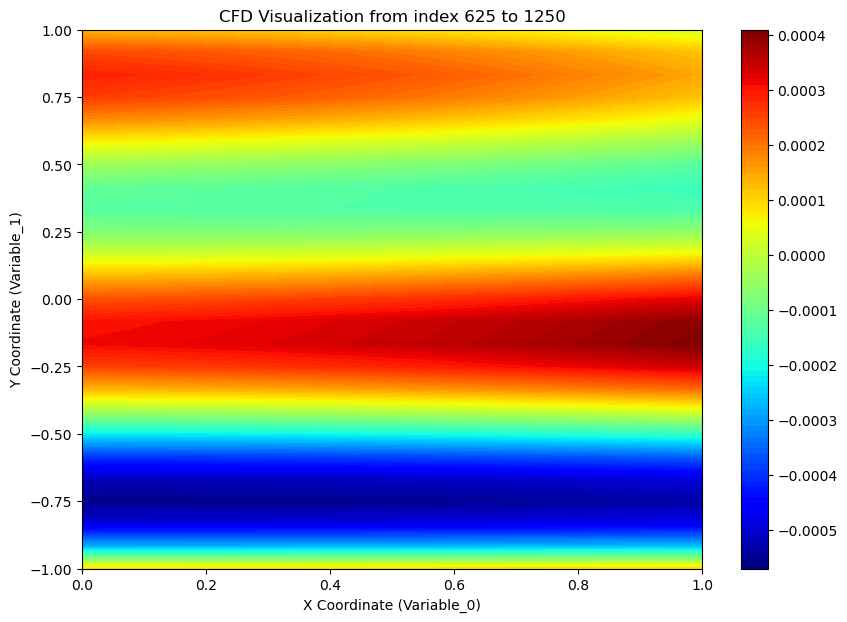

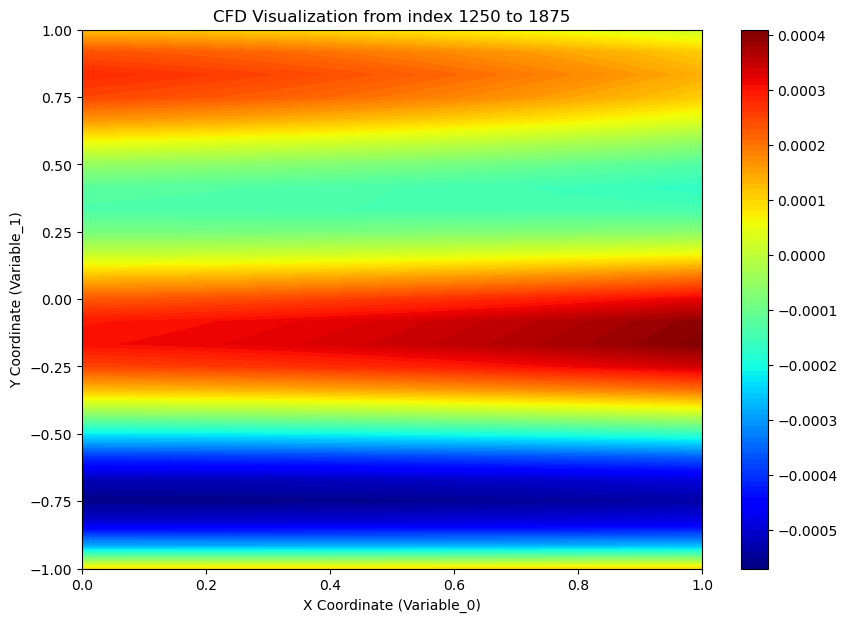

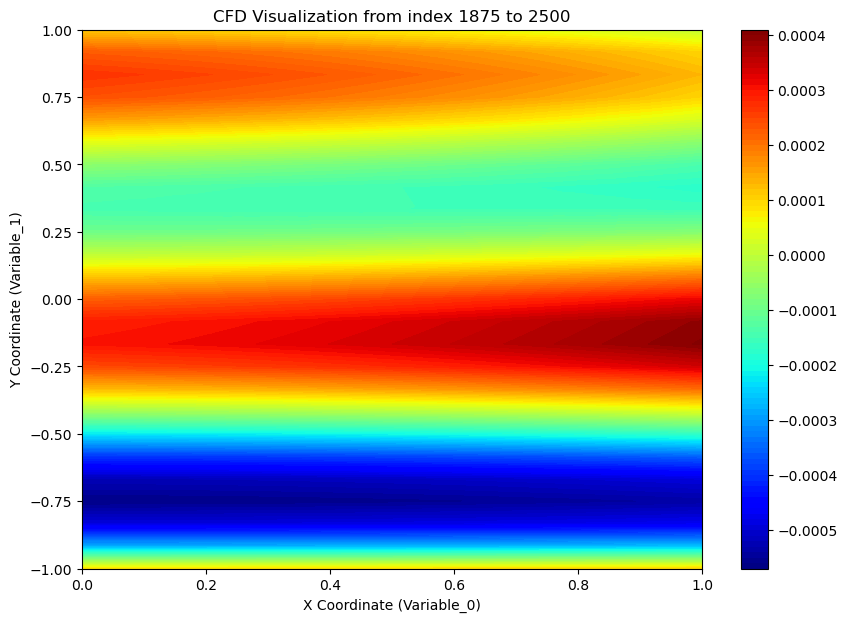

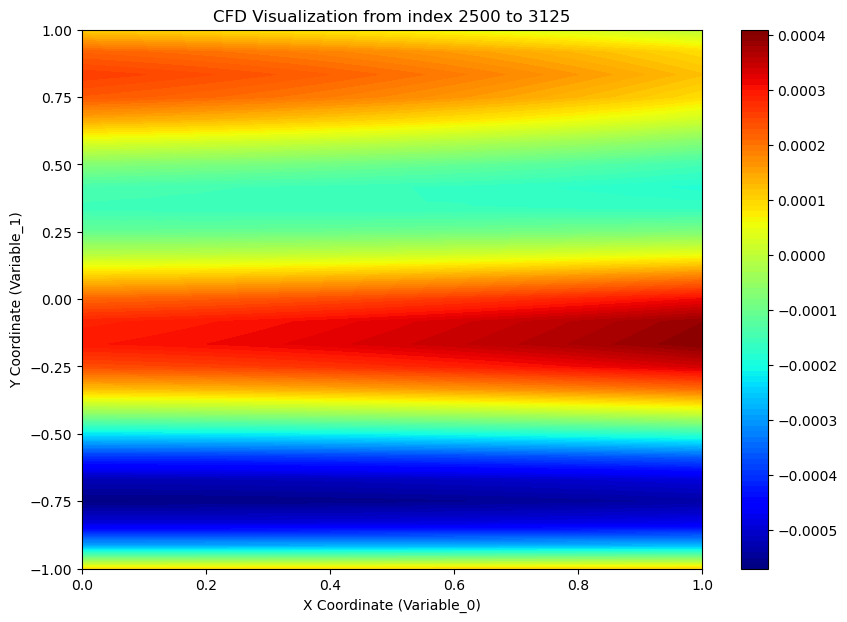

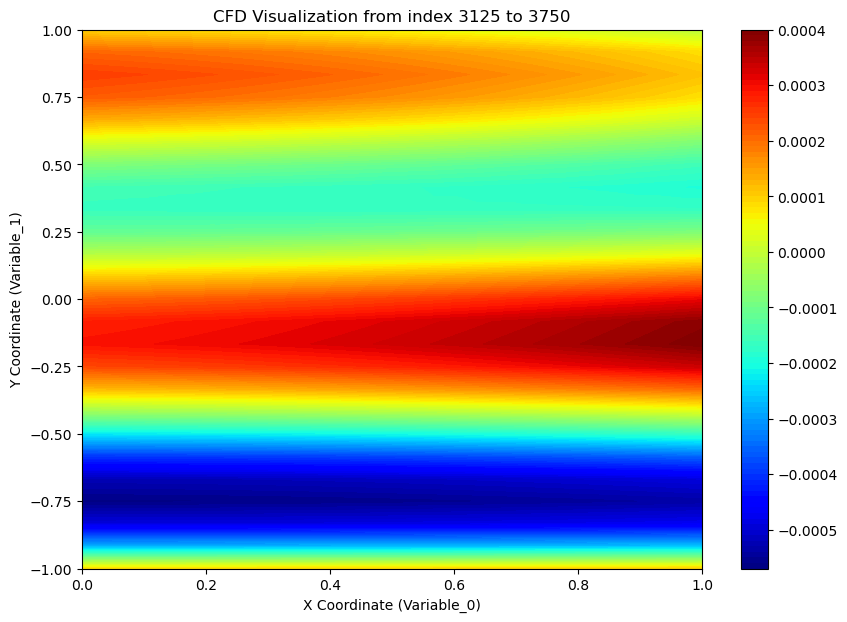

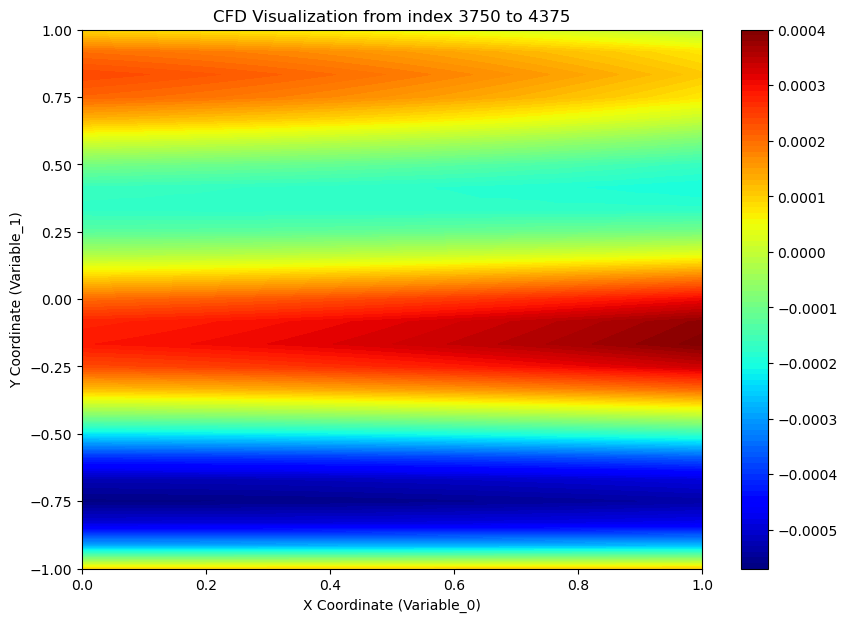

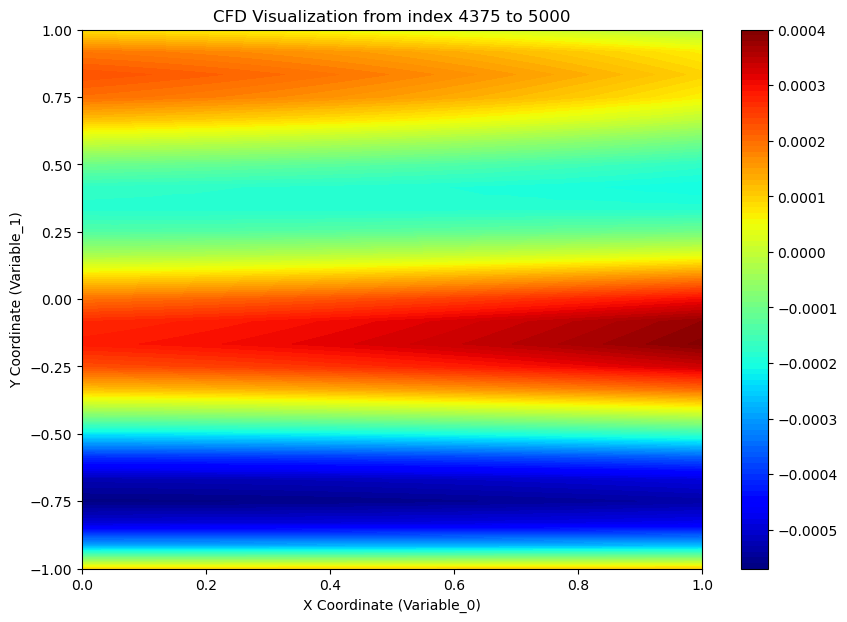

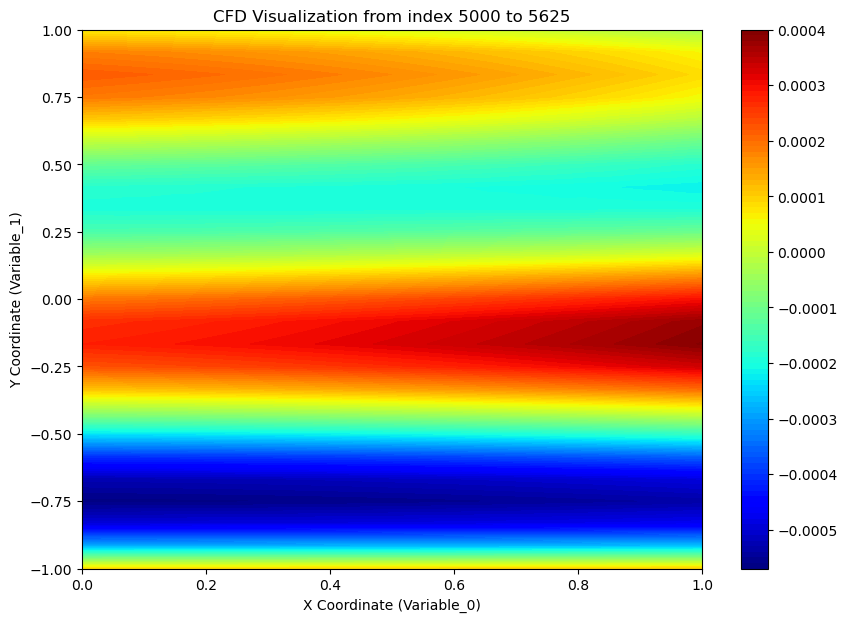

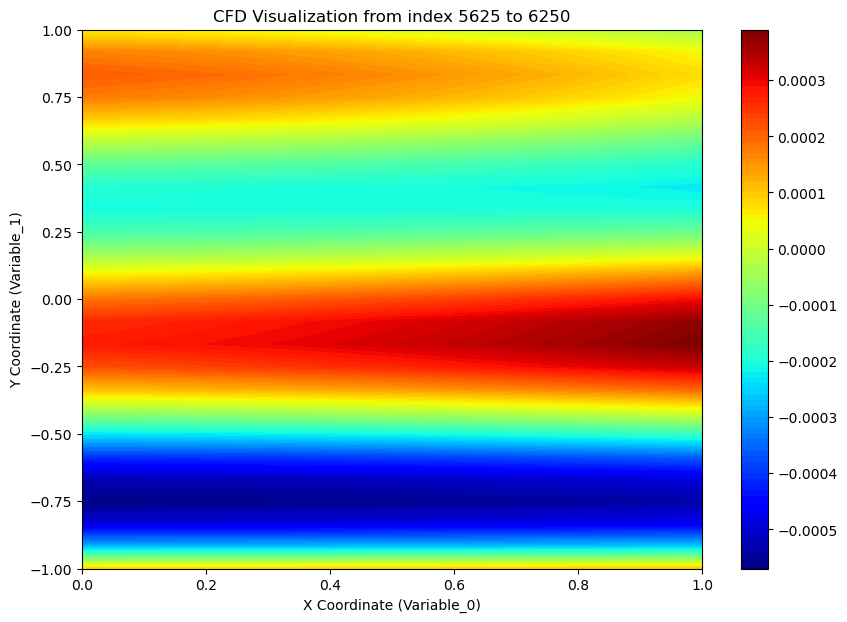

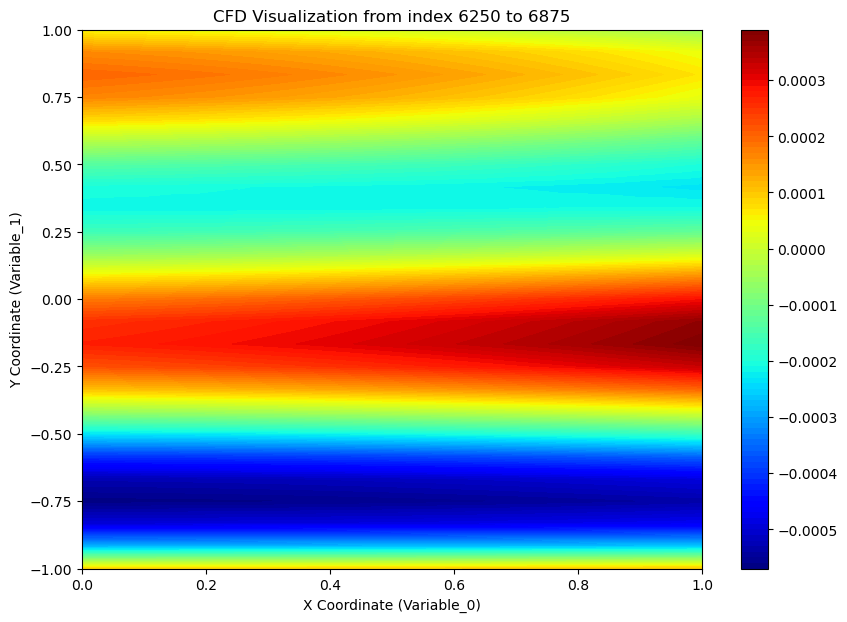

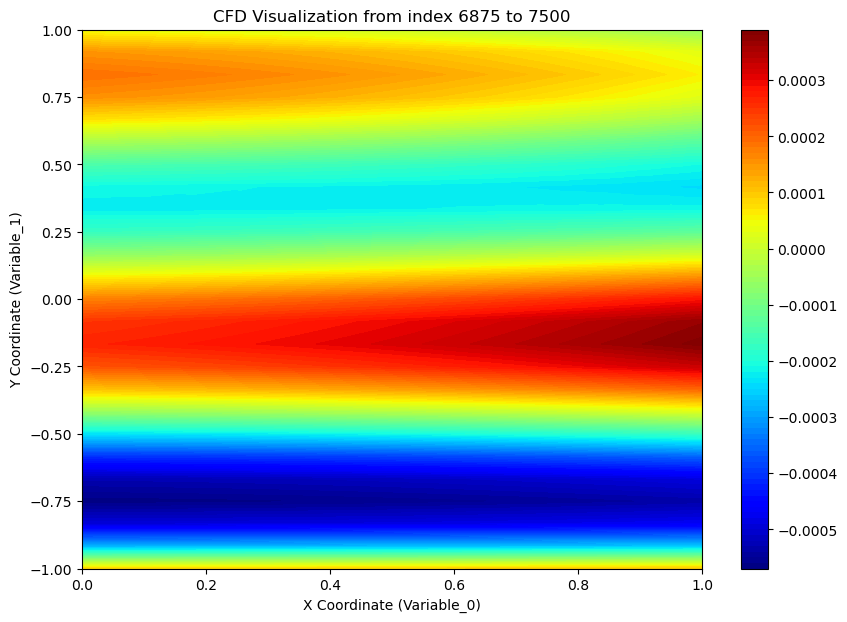

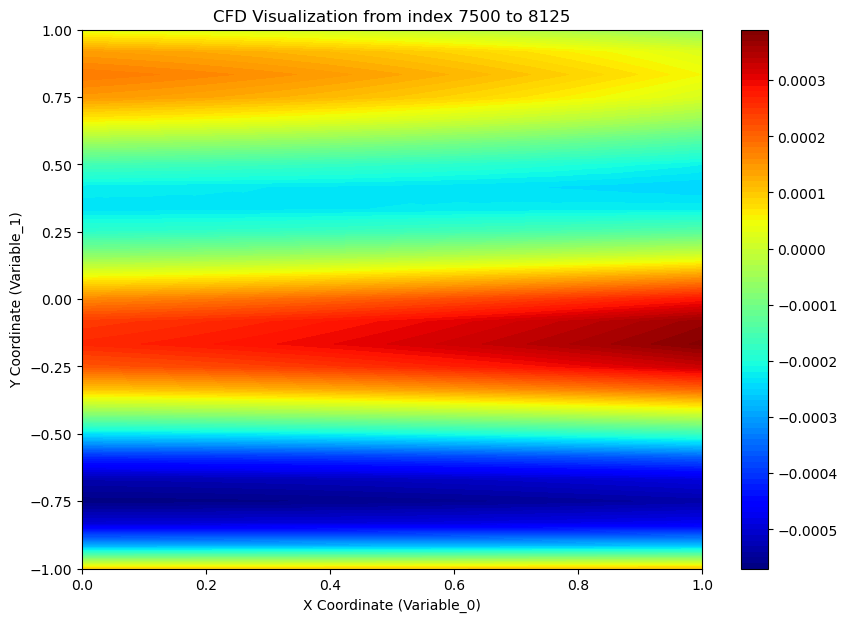

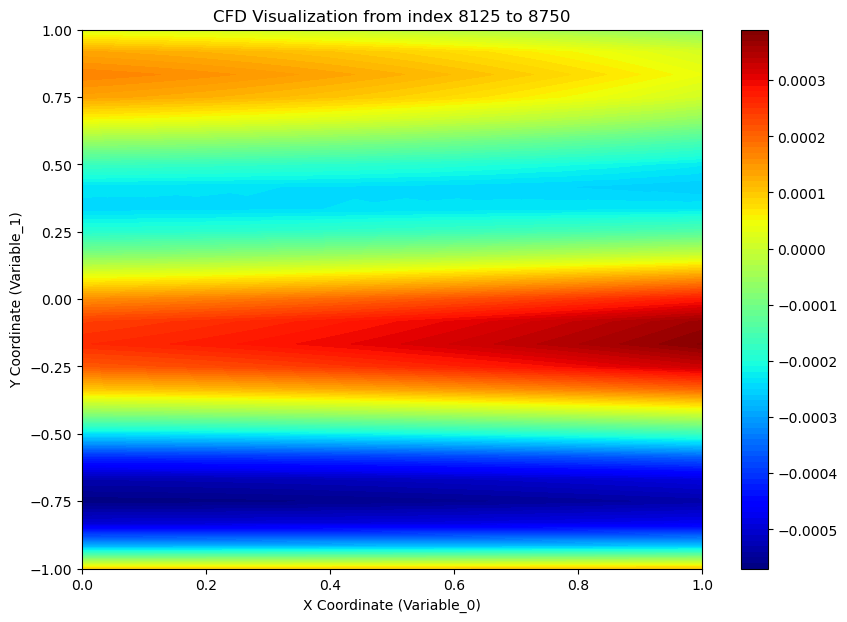

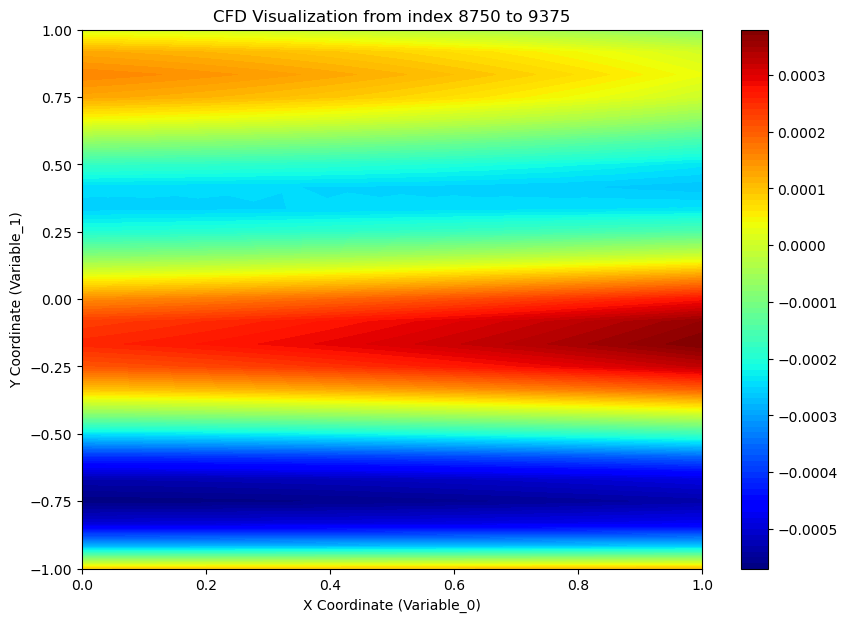

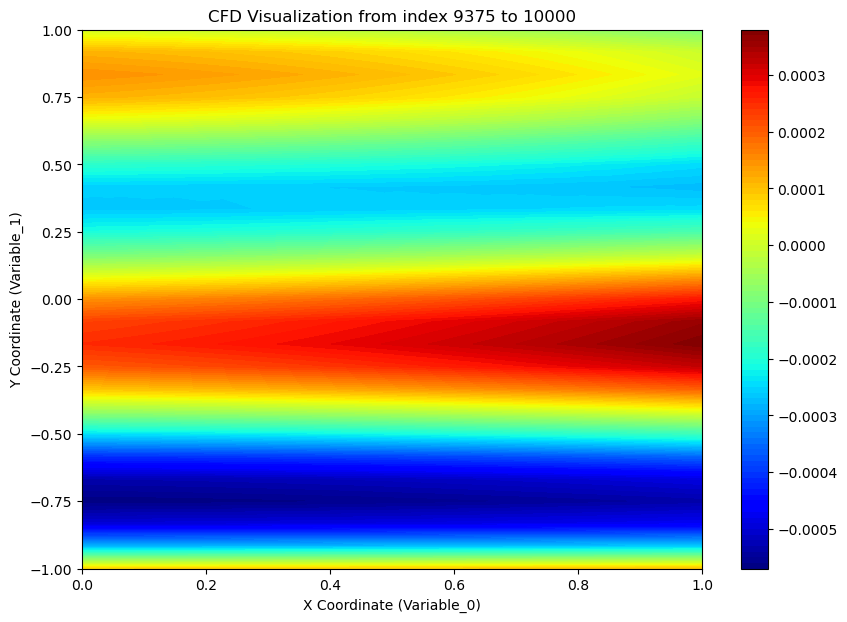

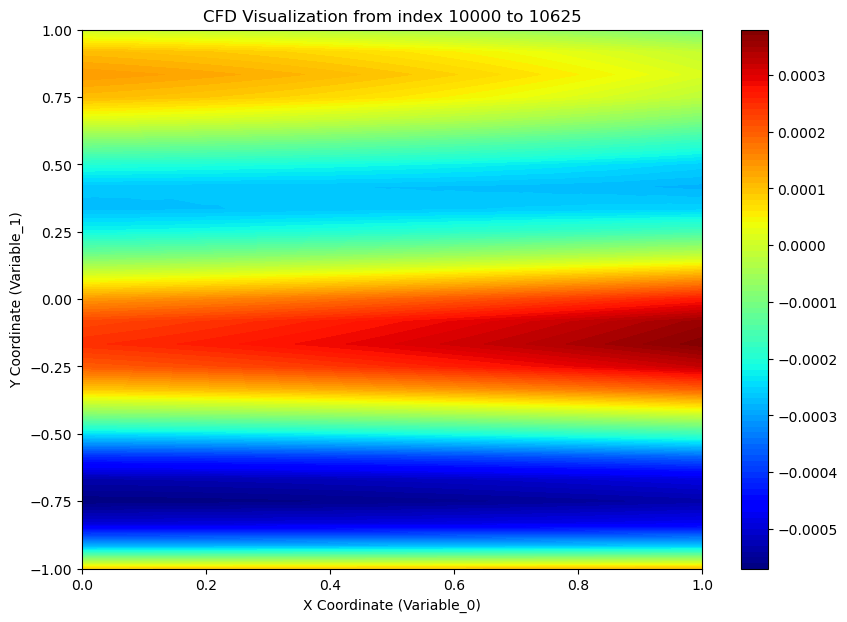

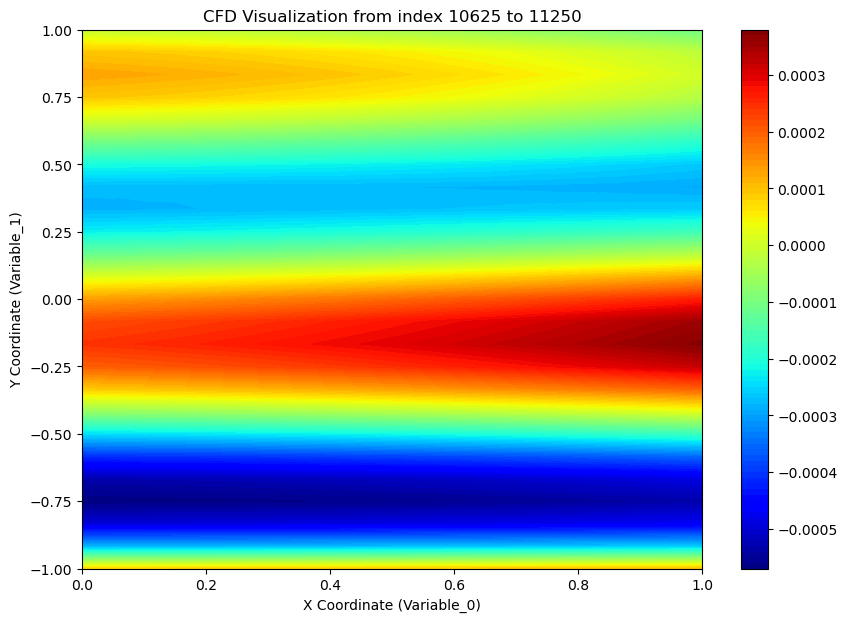

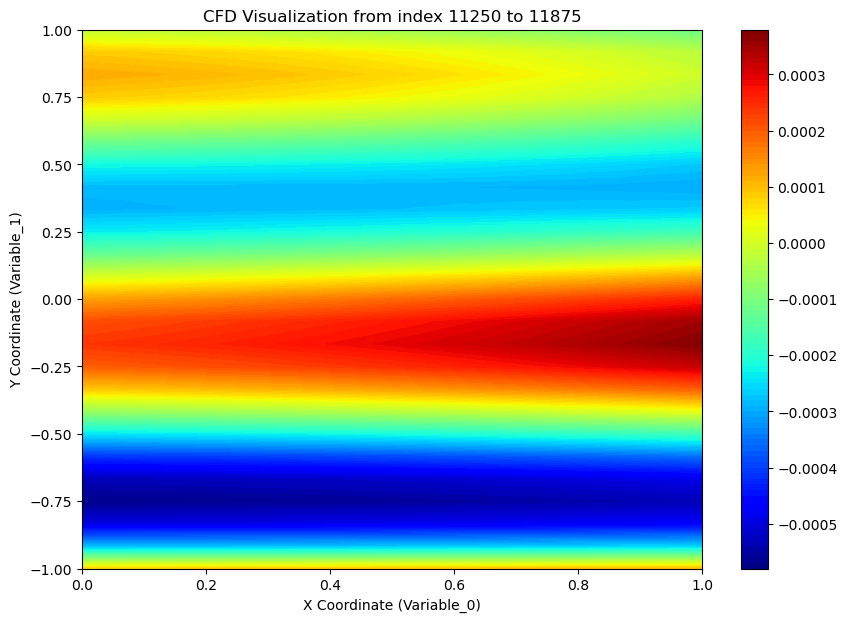

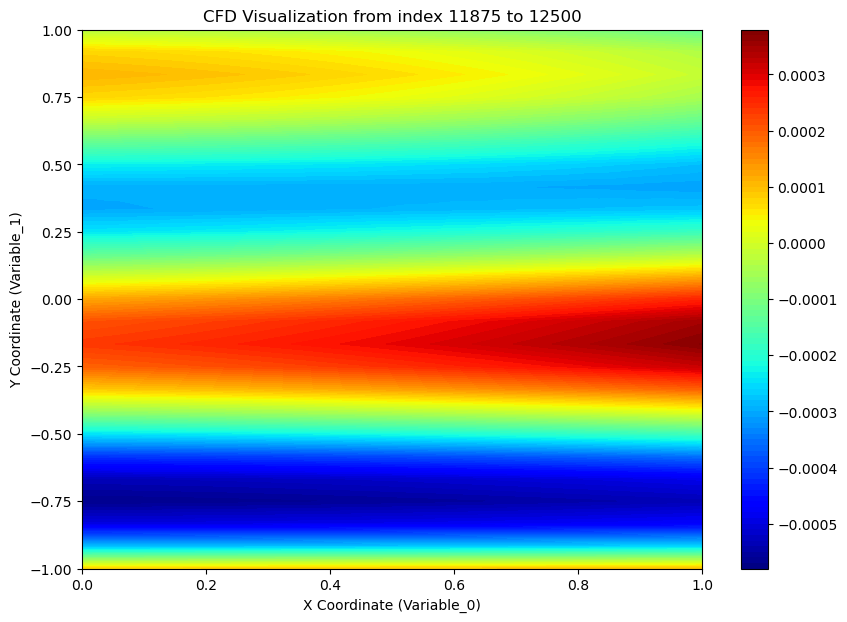

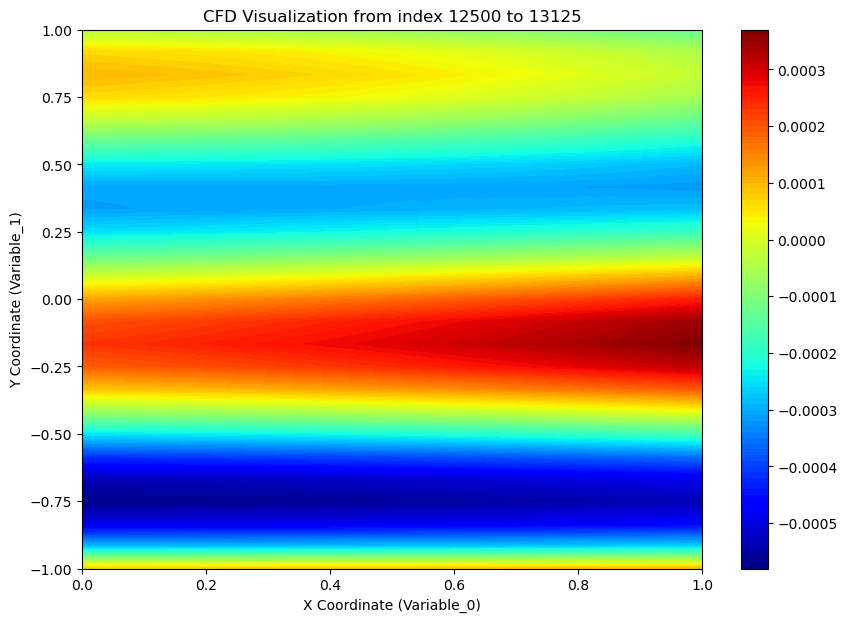

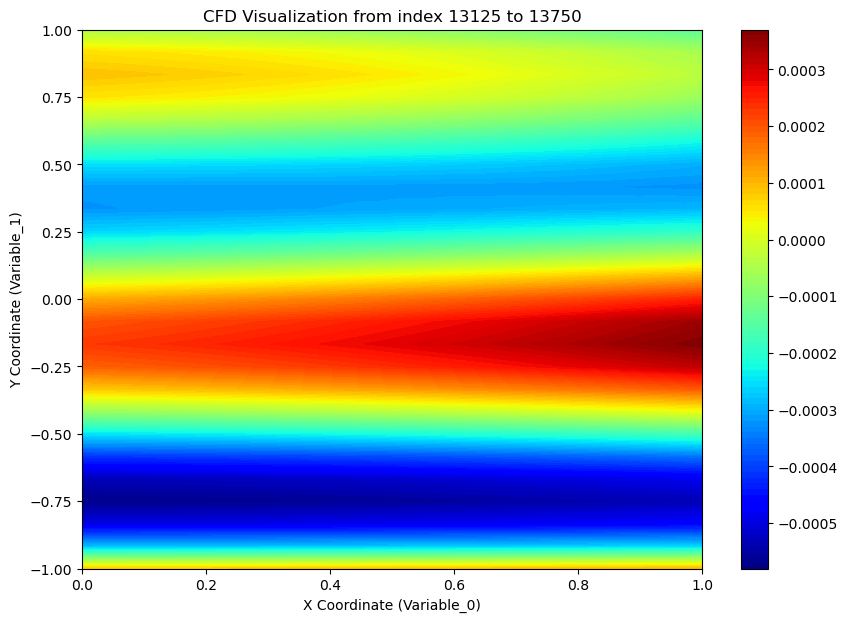

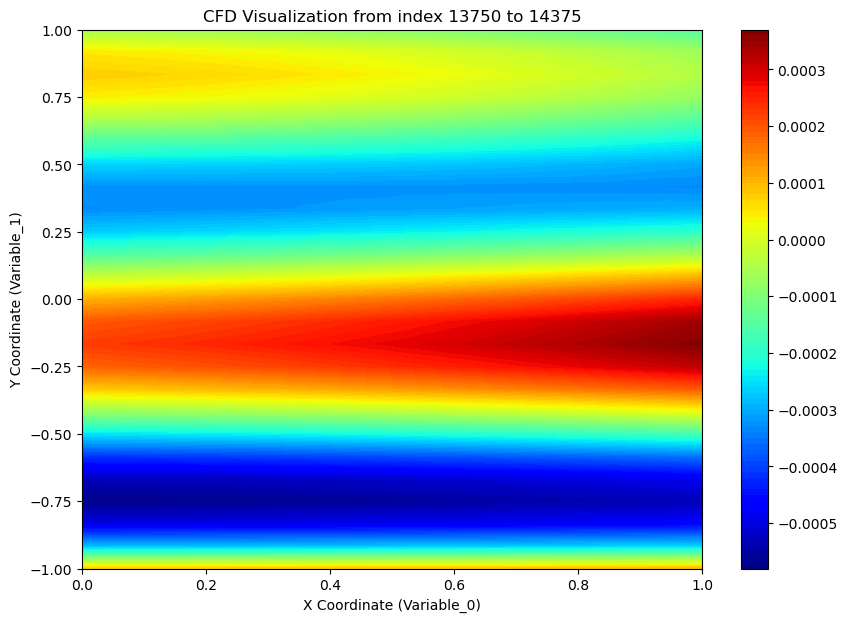

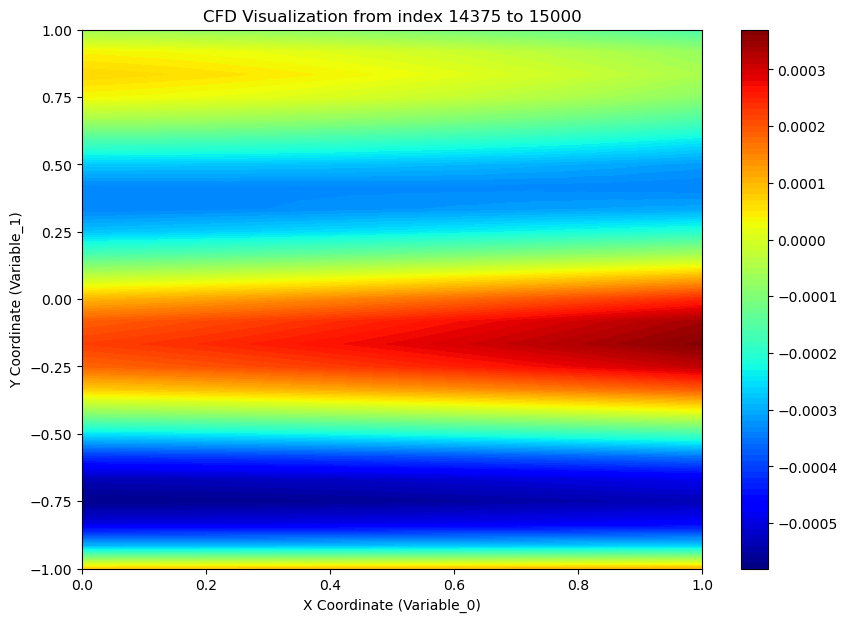

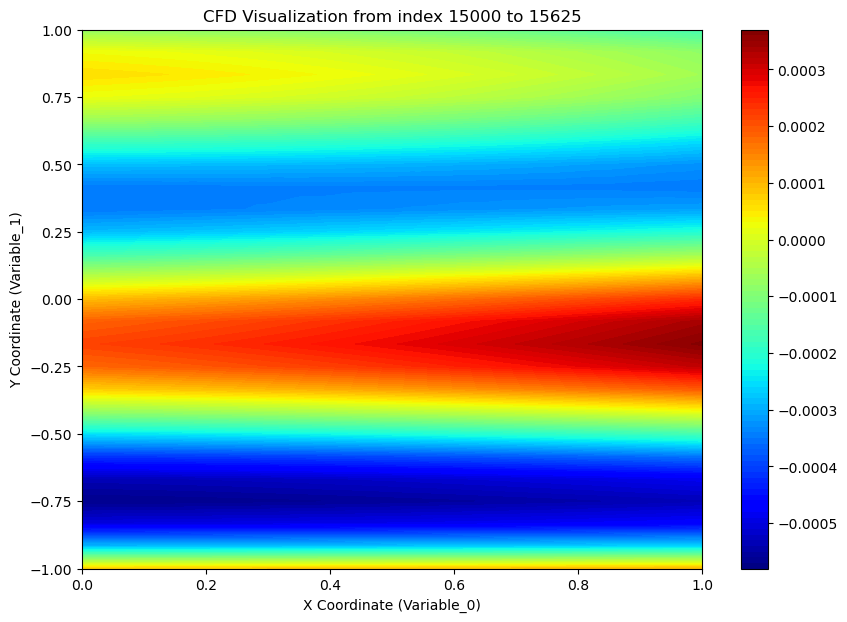

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

path = os.getcwd()
points_df = pd.read_csv(os.path.join(path,'with_filter', 'points.csv'))
predicted_output_df = pd.read_csv(os.path.join(path,'with_filter', 'predicted_output.csv'))

# Merge the dataframes if they are aligned by index
df = pd.concat([points_df, predicted_output_df], axis=1)

# Number of points per plot
points_per_plot = 625

# Calculate the number of plots needed
num_plots = len(df) // points_per_plot

for i in range(num_plots):
    start_index = i * points_per_plot
    end_index = start_index + points_per_plot
    
    # Ensure we don't exceed the dataframe length
    if end_index > len(df):
        end_index = len(df)
    
    # Plotting
    plt.figure(figsize=(10, 7))
    plt.tricontourf(df['Variable_0'][start_index:end_index],
                    df['Variable_1'][start_index:end_index],
                    df['Prediction'][start_index:end_index],
                    levels=100, cmap='jet')
    
    plt.colorbar()
    plt.title(f'CFD Visualization from index {start_index} to {end_index}')
    plt.xlabel('X Coordinate (Variable_0)')
    plt.ylabel('Y Coordinate (Variable_1)')
    plt.show()

# boundary condition why not satisfied for 16x32
# check only the boundary condition in 16x32
# then introduce forcing and check
# then add terms one by one
# check the magnitude of the loss term individually and mateix sizes
# check contributions from differsnt terms in the equation


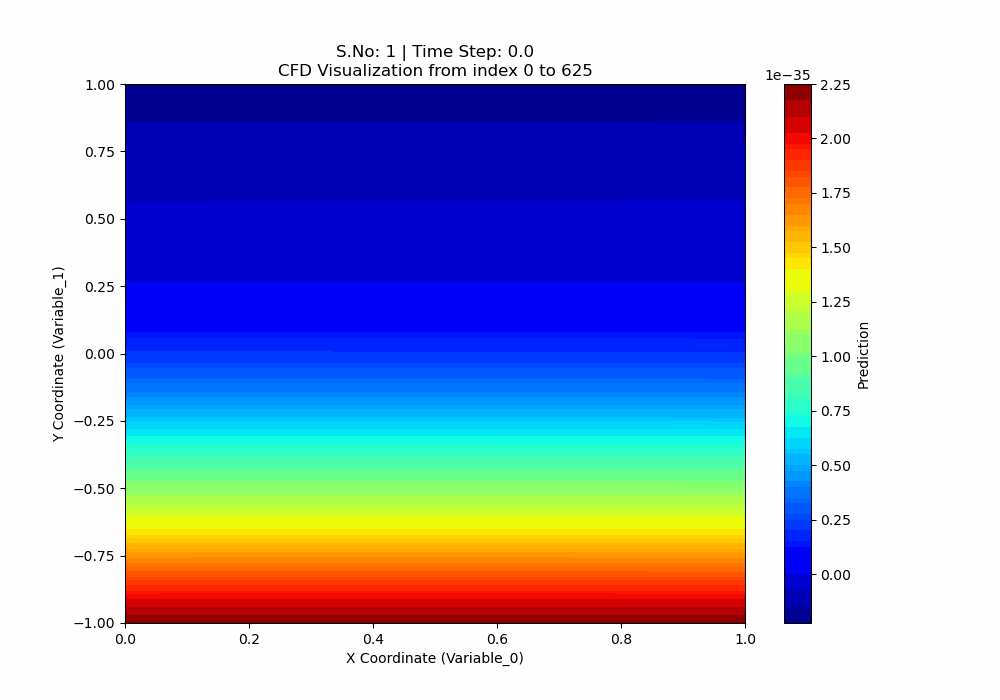

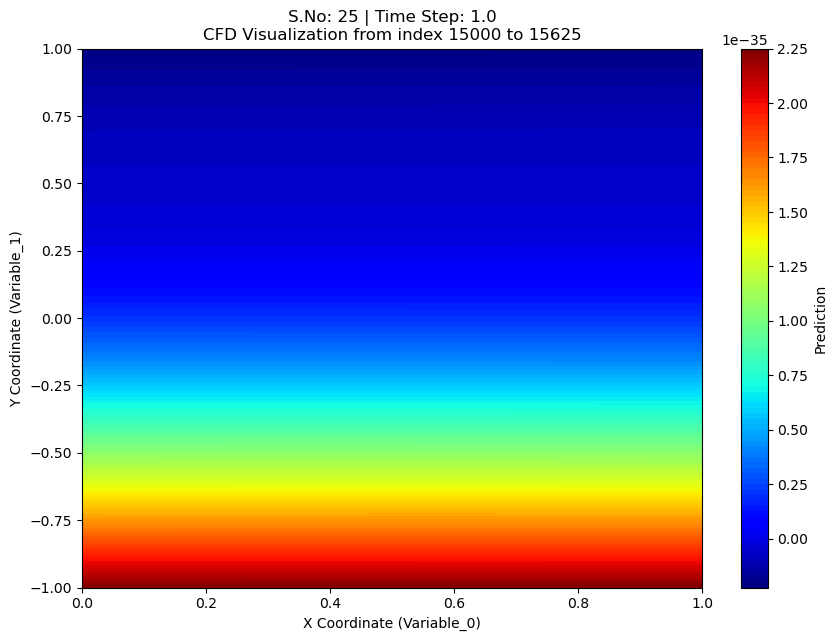

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from IPython.display import Image

path = os.getcwd()
points_df = pd.read_csv(os.path.join(path,'with_filter', 'points.csv'))
predicted_output_df = pd.read_csv(os.path.join(path,'with_filter', 'predicted_output.csv'))

# Merge the dataframes if they are aligned by index
df = pd.concat([points_df, predicted_output_df], axis=1)

# Number of points per plot
points_per_plot = res**2

# Calculate the number of plots needed
num_plots = len(df) // points_per_plot

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

def animate(i):
    ax.clear()
    start_index = i * points_per_plot
    end_index = start_index + points_per_plot
    
    # Ensure we don't exceed the dataframe length
    if end_index > len(df):
        end_index = len(df)
    
    # Plot the contour for Prediction
    contour = ax.tricontourf(df['Variable_0'][start_index:end_index],
                             df['Variable_1'][start_index:end_index],
                             df['Prediction'][start_index:end_index],
                             levels=100, cmap='jet')
    
    # Extract the time step (assuming Variable_2 represents the time)
    time_step = df['Variable_2'].iloc[start_index]
    
    # Set the title with S.No and Time Step
    ax.set_title(f'S.No: {i+1} | Time Step: {time_step}\nCFD Visualization from index {start_index} to {end_index}')
    ax.set_xlabel('X Coordinate (Variable_0)')
    ax.set_ylabel('Y Coordinate (Variable_1)')
    
    return contour  # Return the contour to be used in animation

# Disable interactive plotting
plt.ioff()

# Create the animation and add colorbar once
ani = animation.FuncAnimation(fig, animate, frames=num_plots, repeat=False, blit=False)

# Add colorbar
contour = animate(0)  # Use the first frame to set up the colorbar
fig.colorbar(contour, ax=ax, label='Prediction')

# Re-enable interactive plotting
plt.ion()

# Save the animation as a GIF
ani.save('cfd_animation_with_timestep_and_sno.gif', writer=PillowWriter(fps=2))

# Display the GIF in the notebook
Image(filename='cfd_animation_with_timestep_and_sno.gif')
